# Content

- Code các phần liên quan tới xử lý text:
    1. Từ raw data => xử lý lấy 512 token đầu, bỏ câu ngắn => json
    2. Abtrac2Extract gen nhãn cho từng câu trong multi doc => Chuyển từ multi doc => single doc => đưa qua model finetune bert1
    3. Predict cho từng single doc => từ top 7 sentence mỗi single doc gộp lại lấy 512 token bằng hàm đã tạo (Multi doc -> single doc)
    4. Generate nhãn cho văn bản đã gộp => finetune bert2

# Config

In [ ]:
class DataConfig():
    oracle_mode = 'greedy'  # ['combination', 'greedy']
    min_src_ntokens = 5
    max_src_ntokens = 200  # check laij, 80 ok roi
    min_nsents = 3
    max_nsents = 100

In [ ]:
class ModelConfig():
    encoder = 'classifier'  # choices=['classifier','transformer','rnn','baseline']
    mode = 'train'  # choices=['train','validate','test']
    temp_dir = '../temp'
    batch_size = 64
    hidden_size = 128
    ff_size = 512
    heads = 4
    inter_layers = 2
    rnn_size = 512

    param_init = 0.0
    param_init_glorot = False
    dropout = 0.1
    optim = 'adam'
    lr = 1e-3
    beta1 = 0.9
    beta2 = 0.999
    warmup_steps = 5000
    max_grad_norm = 30


    accum_count = 1
    world_size = 1

In [ ]:
bert_config_uncased_base = {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

# Import requirements and download data

## Install pyrouge

In [ ]:
!pip install -q pyrouge --upgrade
!pip install -q https://github.com/bheinzerling/pyrouge/archive/master.zip
!pip install -q pyrouge
# !pip show pyrouge
!git clone https://github.com/andersjo/pyrouge.git
from pyrouge import Rouge155
!pyrouge_set_rouge_path '/content/pyrouge/tools/ROUGE-1.5.5'

!sudo apt-get install -qq libxml-parser-perl

In [ ]:
%%shell
cd pyrouge/tools/ROUGE-1.5.5/data
rm WordNet-2.0.exc.db # only if exist
cd WordNet-2.0-Exceptions
rm WordNet-2.0.exc.db # only if exist

./buildExeptionDB.pl . exc WordNet-2.0.exc.db
cd ../
ln -s WordNet-2.0-Exceptions/WordNet-2.0.exc.db WordNet-2.0.exc.db

In [ ]:
!pip install -q folium==0.2.1 urllib3==1.25.4 pytorch_pretrained_bert tensorboardX

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 133kB 12.1MB/s 
     |████████████████████████████████| 133kB 14.6MB/s 
     |████████████████████████████████| 122kB 16.0MB/s 
     |████████████████████████████████| 133kB 14.6MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 7.5MB 15.4MB/s 


In [ ]:
# Train
!gdown --id 1vWfhWIj-UpV_bY-zcu7lw4m9z8hLkF0r
!gdown --id 1QVgswwhVTkd3VLCzajK6eVkcrSWEK6kq
# Valid
!gdown --id 1L2dk4ThZ-Bau9rIQpMG8I75R15FpLE-B
!gdown --id 1Y1lBbBU5Q0aJMqLhYEOdEtTqQ85XnRRM
# Test
!gdown --id 1_jyJOVkAfRafJQkH2HLYhw4NTKU5f4bq
!gdown --id 1CX_YcgQ3WwNC1fXBpMfwMXFPCqsd9Lbp

Downloading...
From: https://drive.google.com/uc?id=1vWfhWIj-UpV_bY-zcu7lw4m9z8hLkF0r
To: /content/train.src
550MB [00:03, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QVgswwhVTkd3VLCzajK6eVkcrSWEK6kq
To: /content/train.tgt
58.8MB [00:00, 112MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1L2dk4ThZ-Bau9rIQpMG8I75R15FpLE-B
To: /content/val.src
67.2MB [00:00, 145MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1Y1lBbBU5Q0aJMqLhYEOdEtTqQ85XnRRM
To: /content/val.tgt
7.30MB [00:00, 34.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_jyJOVkAfRafJQkH2HLYhw4NTKU5f4bq
To: /content/test.src
69.4MB [00:00, 84.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CX_YcgQ3WwNC1fXBpMfwMXFPCqsd9Lbp
To: /content/test.tgt
7.31MB [00:00, 44.6MB/s]


In [ ]:
!cp -r /content/drive/MyDrive/BertSumExt/BertSum .

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import json
import os
import nltk
import gc
import re
import joblib
import numpy as np
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

from copy import deepcopy
from tqdm.notebook import tqdm
from pytorch_pretrained_bert import BertTokenizer

!mkdir src
!cp /content/drive/MyDrive/Colab\ Notebooks/20202/src/*.py src/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import sys
sys.path.append('/content/BertSum/src')

In [ ]:
from others.utils import test_rouge, rouge_results_to_str

# Truncate single doc

In [ ]:
from src import abtract2extract
summary_size = 4
def greedy_extract(train_src, train_tgt, is_test=False):
    data = {}
    doc_list = train_src.replace('NEWLINE_CHAR', '\n').split('|||||')  # pag

    doc_list = [d for d in doc_list if len(d.split()) > 3]
    # keep 510 first token
    n = 510   #// len(doc_list) => for keep 510 // S
    doc_list = [' '.join(word_tokenize(d)[:n]) for d in doc_list]

    doc_sent_list = []
    for doc in doc_list: # min 5 word for a sent
        doc_sent_list.append([word_tokenize(x) for x in sent_tokenize(doc)\
                              if len(word_tokenize(x))>4])
        
    
    doc_sent_list = [d for d in doc_sent_list if len(d) > 2] # min sent = 3 sent for each paragraph
    full_sent_list = [sent for pag in doc_sent_list for sent in pag]

    abstract_sent_list = [word_tokenize(x) for x in sent_tokenize(train_tgt)]

    num_sent_extract = len(sent_tokenize(train_tgt))+1  # todo: +1 or not
    if is_test:
        num_sent_extract = 10 # for test
    idx_extract = abtract2extract.greedy_selection(full_sent_list,\
                                                   abstract_sent_list, num_sent_extract)

    data['src_doc_sent_list'] = deepcopy(doc_sent_list)
    assert data['src_doc_sent_list'] == doc_sent_list, 'Copy src bug!'

    data['tgt_sent_list'] = deepcopy(abstract_sent_list)
    assert data['tgt_sent_list'] == abstract_sent_list, 'Copy tgt bug!'

    data['idx_extract'] = sorted(deepcopy(idx_extract))
    assert deepcopy(idx_extract) == idx_extract, 'Copy idx extract bug!'
   
    return data

In [ ]:
with open('val.src', 'r') as file:
    train_src = file.readlines()

with open('val.tgt', 'r') as file:
    train_tgt = file.readlines()

In [ ]:
processed_data = []
k = 0
for i, (src, tgt) in tqdm(enumerate(zip(train_src[k:], train_tgt[k:])), total=len(train_src)):
    data = greedy_extract(src, tgt)
    if data['idx_extract']:
        processed_data.append(data)
    else:
        print(f"Filter out multidoc {i}")

Filter out multidoc 161
Filter out multidoc 308
Filter out multidoc 405
Filter out multidoc 715
Filter out multidoc 1082
Filter out multidoc 1110
Filter out multidoc 1736
Filter out multidoc 2134
Filter out multidoc 2303
Filter out multidoc 2304
Filter out multidoc 2732
Filter out multidoc 2831
Filter out multidoc 2949
Filter out multidoc 3792
Filter out multidoc 3977
Filter out multidoc 4187
Filter out multidoc 4850
Filter out multidoc 5387



In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/20202/data/data_val_extract_filter_512.json', 'w') as file:
#     json.dump(processed_data, file)

In [ ]:
with open('/content/data_val_extract_filter_512.json', 'w') as file:
    json.dump(processed_data, file)

## Test rouge on generated label

### Pyrouge

In [ ]:
# for pyrouge test
# processed_data[0].keys()
file_cand = open('candidate.txt', 'w')
file_ref = open('reference.txt', 'w')
for doc in tqdm(processed_data):
    full_sent_list = [sent for pag in doc['src_doc_sent_list'] for sent in pag]
    sent_extracted = [full_sent_list[i] for i in doc['idx_extract']]
    
    cand = ' '.join([' '.join(s) for s in sent_extracted])
    ref = ' '.join([' '.join(s) for s in doc['tgt_sent_list']])
    file_cand.write(cand+'\n')
    file_ref.write(ref+'\n')
file_cand.close()
file_ref.close()
!mkdir '/content/temp'
test_rouge('/content/temp', '/content/candidate.txt', '/content/reference.txt')

mkdir: cannot create directory ‘/content/temp’: File exists
5604
5604


2021-05-07 08:29:45,398 [MainThread  ] [INFO ]  Writing summaries.
2021-05-07 08:29:45,401 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /content/temp/tmpm3_v_egu/system and model files to /content/temp/tmpm3_v_egu/model.
2021-05-07 08:29:45,406 [MainThread  ] [INFO ]  Processing files in /content/temp/rouge-tmp-2021-05-07-08-29-44/candidate/.
2021-05-07 08:29:46,175 [MainThread  ] [INFO ]  Saved processed files to /content/temp/tmpm3_v_egu/system.
2021-05-07 08:29:46,178 [MainThread  ] [INFO ]  Processing files in /content/temp/rouge-tmp-2021-05-07-08-29-44/reference/.
2021-05-07 08:29:47,065 [MainThread  ] [INFO ]  Saved processed files to /content/temp/tmpm3_v_egu/model.
2021-05-07 08:29:47,127 [MainThread  ] [INFO ]  Written ROUGE configuration to /content/temp/tmpmxb9rwrr/rouge_conf.xml
2021-05-07 08:29:47,129 [MainThread  ] [INFO ]  Running ROUGE with command /content/pyrouge/tools/ROUGE-1.5.5/ROUGE-1.5.5.pl -e /content/pyrouge/tools/ROUGE-1.5.5/data -c 95 

---------------------------------------------
1 ROUGE-1 Average_R: 0.53704 (95%-conf.int. 0.53398 - 0.53997)
1 ROUGE-1 Average_P: 0.63339 (95%-conf.int. 0.62979 - 0.63696)
1 ROUGE-1 Average_F: 0.57215 (95%-conf.int. 0.56946 - 0.57473)
---------------------------------------------
1 ROUGE-2 Average_R: 0.27851 (95%-conf.int. 0.27496 - 0.28220)
1 ROUGE-2 Average_P: 0.33759 (95%-conf.int. 0.33277 - 0.34249)
1 ROUGE-2 Average_F: 0.30034 (95%-conf.int. 0.29651 - 0.30447)
---------------------------------------------
1 ROUGE-L Average_R: 0.28279 (95%-conf.int. 0.27969 - 0.28602)
1 ROUGE-L Average_P: 0.34171 (95%-conf.int. 0.33727 - 0.34599)
1 ROUGE-L Average_F: 0.30434 (95%-conf.int. 0.30102 - 0.30778)



{'rouge_1_f_score': 0.57215,
 'rouge_1_f_score_cb': 0.56946,
 'rouge_1_f_score_ce': 0.57473,
 'rouge_1_precision': 0.63339,
 'rouge_1_precision_cb': 0.62979,
 'rouge_1_precision_ce': 0.63696,
 'rouge_1_recall': 0.53704,
 'rouge_1_recall_cb': 0.53398,
 'rouge_1_recall_ce': 0.53997,
 'rouge_2_f_score': 0.30034,
 'rouge_2_f_score_cb': 0.29651,
 'rouge_2_f_score_ce': 0.30447,
 'rouge_2_precision': 0.33759,
 'rouge_2_precision_cb': 0.33277,
 'rouge_2_precision_ce': 0.34249,
 'rouge_2_recall': 0.27851,
 'rouge_2_recall_cb': 0.27496,
 'rouge_2_recall_ce': 0.2822,
 'rouge_l_f_score': 0.30434,
 'rouge_l_f_score_cb': 0.30102,
 'rouge_l_f_score_ce': 0.30778,
 'rouge_l_precision': 0.34171,
 'rouge_l_precision_cb': 0.33727,
 'rouge_l_precision_ce': 0.34599,
 'rouge_l_recall': 0.28279,
 'rouge_l_recall_cb': 0.27969,
 'rouge_l_recall_ce': 0.28602}

### Rouge on origin - my rouge

In [ ]:
# evaluate abtract2extract peformance
f1 = []
p = []
r = []

for i, data in tqdm(enumerate(processed_data), total=len(processed_data)):
    full_sent_list = [sent for pag in data['src_doc_sent_list'] for sent in pag]
    sent_extracted = [full_sent_list[i] for i in data['idx_extract']]

    candidate = set.union(*map(set, sent_extracted))
    gold = set.union(*map(set, data['tgt_sent_list']))

    f1.append(abtract2extract.cal_rouge(candidate, gold)['f'])
    p.append(abtract2extract.cal_rouge(candidate, gold)['p'])
    r.append(abtract2extract.cal_rouge(candidate, gold)['r'])

print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.5337158984544684
Precidion: 0.5856361582834588
Recall: 0.4990845447154862


### Prepocessing before caculate rouge

In [ ]:
f1 = []
p = []
r = []

for i, data in tqdm(enumerate(processed_data), total=len(processed_data)):
    full_sent_list = [sent for pag in data['src_doc_sent_list'] for sent in pag]
    sent_extracted = [full_sent_list[i] for i in data['idx_extract']]

    candidate = set.union(*map(set, sent_extracted))
    candidate = set([x.lower() for x in candidate if x.isalpha() or x.isdigit()])

    gold = set.union(*map(set, data['tgt_sent_list']))
    gold = set([x.lower() for x in gold if x.isalpha() or x.isdigit()])

    f1.append(abtract2extract.cal_rouge(candidate, gold)['f'])
    p.append(abtract2extract.cal_rouge(candidate, gold)['p'])
    r.append(abtract2extract.cal_rouge(candidate, gold)['r'])

print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.5475245169678181
Precidion: 0.6010439280885476
Recall: 0.511928539707526


# Generate label for bert extract finetune 1
 

## Multi doc to single doc

In [ ]:
def json2bert_single(json_file):
    """
    Convert từ multidoc + label ban đầu - dataset gốc => single doc + label tương ứng
    """

    with open(json_file, 'r') as file:
        json_data = json.load(file)
        
    sigle_doc_format = []
    for i, data in tqdm(enumerate(json_data), total=len(json_data)):
        idx_start = 0
        total_doc = len(data['src_doc_sent_list'])
        for j, parag in enumerate(data['src_doc_sent_list']):
            # if len(parag) < 3:  # Chỉ lấy đoạn có số câu >2
            #     continue
            sent_idx_extract = []
            # origin_sent_idx_extract = []
            single_doc = {}
            n = len(parag)
            for idx in data['idx_extract']:
                if idx_start <= idx < idx_start+n:
                    sent_idx_extract.append(idx-idx_start)
                    # origin_sent_idx_extract.append(idx)
            
            single_doc['src'] = deepcopy(parag)
            single_doc['idx_start'] = idx_start
            single_doc['idx_extract'] = sorted(deepcopy(sent_idx_extract))
            # single_doc['origin_idx_extract'] = sorted(deepcopy(origin_sent_idx_extract))
            single_doc['id'] = f"{i}_{j}"
            single_doc['n_sent'] = n
            single_doc['total_doc'] = total_doc
            single_doc['multi_idx_extract'] = sorted(deepcopy(data['idx_extract']))
            sigle_doc_format.append(deepcopy(single_doc))

            idx_start += n
        # break
    return sigle_doc_format


In [ ]:
# sigle_doc_format = json2bert_single('/content/data_val_extract_filter_512.json')
sigle_doc_format = json2bert_single('/content/drive/MyDrive/Colab Notebooks/20202/data/data_test_extract_filter_512.json')


In [ ]:
len(sigle_doc_format)

14232

In [ ]:
sigle_doc_format[1].keys()
# => fine tune bert chỉ dùng tới src và idx_extract

dict_keys(['src', 'idx_start', 'idx_extract', 'id', 'n_sent', 'total_doc', 'multi_idx_extract'])

## Convert to bert data format for finetuning

In [ ]:
class BertData():
    def __init__(self, args):
        self.args = args
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        self.sep_vid = self.tokenizer.vocab['[SEP]']
        self.cls_vid = self.tokenizer.vocab['[CLS]']
        self.pad_vid = self.tokenizer.vocab['[PAD]']

    def preprocess(self, src, oracle_ids=[]):
        # Test => oracle_ids=[]
        if (len(src) == 0):
            return None

        original_src_txt = [' '.join(s) for s in src]

        labels = [0] * len(src)
        for l in oracle_ids:
            labels[l] = 1

        idxs = [i for i, s in enumerate(src) if (len(s) >= self.args.min_src_ntokens)]

        src = [src[i][:self.args.max_src_ntokens] for i in idxs]  # token toi da cua 1 cau
        labels = [labels[i] for i in idxs] # bỏ câu ngắn
        src = src[:self.args.max_nsents]
        labels = labels[:self.args.max_nsents] # cắt bớt đoạn dài

        if (len(src) < self.args.min_nsents):
            return None
        if (len(labels) == 0):
            return None

        src_txt = [' '.join(sent) for sent in src]
        # text = [' '.join(ex['src_txt'][i].split()[:self.args.max_src_ntokens]) for i in idxs]
        # text = [_clean(t) for t in text]
        text = ' [SEP] [CLS] '.join(src_txt)
        src_subtokens = self.tokenizer.tokenize(text)
        src_subtokens = src_subtokens[:510]
        src_subtokens = ['[CLS]'] + src_subtokens + ['[SEP]']

        src_subtoken_idxs = self.tokenizer.convert_tokens_to_ids(src_subtokens)
        _segs = [-1] + [i for i, t in enumerate(src_subtoken_idxs) if t == self.sep_vid]
        segs = [_segs[i] - _segs[i - 1] for i in range(1, len(_segs))]
        segments_ids = []
        for i, s in enumerate(segs):
            if (i % 2 == 0):
                segments_ids += s * [0]
            else:
                segments_ids += s * [1]
        cls_ids = [i for i, t in enumerate(src_subtoken_idxs) if t == self.cls_vid]
        labels = labels[:len(cls_ids)]

        # tgt_txt = '<q>'.join([' '.join(tt) for tt in tgt])
        src_txt = [original_src_txt[i] for i in idxs]
        return src_subtoken_idxs, labels, segments_ids, cls_ids,# src_txt, tgt_txt

In [ ]:
bert_data_config = DataConfig()
bert_data = BertData(bert_data_config)

100%|██████████| 231508/231508 [00:00<00:00, 889934.75B/s]


In [ ]:
test_data = []
for i in tqdm(range(len(sigle_doc_format))):
    data = bert_data.preprocess(sigle_doc_format[i]['src'], sigle_doc_format[i]['idx_extract'])
    assert data is not None, 'Data after preprocess must be not None!'
    test_data.append(data)

In [ ]:
gc.collect()

0

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/20202/data/bert_format_val_512.json', 'w') as file:
#     json.dump(test_data, file)
with open('/content/drive/MyDrive/Colab Notebooks/20202/data/bert_format_val_512.json', 'r') as file:
    test_data = json.load(file)

In [ ]:
# dùng data này để finetune luôn
with open('/content/bert_format_val_512.json', 'w') as file:
    json.dump(test_data, file)

# Truncate data from multidoc => 512 token

Đầu vào:

    - File single doc
    - Kết quả predict của bert single

Đầu ra:

    - Single doc <=512 token

In [ ]:
gc.collect()

466

In [ ]:
result_single = joblib.load('/content/drive/MyDrive/Colab Notebooks/20202/data/result_total_test7.joblib')
arg_sent = []
for rs in result_single:
    arg_sent.append(np.argsort(-rs, axis=1)[:, :7])
arg_sent = np.concatenate(arg_sent)

In [ ]:
len(sigle_doc_format), arg_sent.shape

(14232, (14232, 7))

In [ ]:
# sigle_doc_format = json2bert_single('/content/data_val_extract_filter_512.json')
for doc, idx_predict in zip(sigle_doc_format, arg_sent[:len(sigle_doc_format)]):
    doc['idx_predict'] = list(map(int, idx_predict))  # decrease priority

### Single doc to multi doc

In [ ]:
def single2multi(single_docs):
    """
    list single doc to multi docs
    """
    multi_docs = []
    for doc in single_docs:
        para_infor = {'src': doc['src'],\
                      'selected_index':doc['idx_predict'],\
                      'p_id': doc['id']}
        if doc['idx_start'] == 0:  # new paragraph
            multi_docs.append([para_infor])
        else:
            multi_docs[-1].append(para_infor)
    return multi_docs


### Caculate sentence similarity

In [ ]:
def get_similarity(k_sent, q_sent):
    # q_sent, k_sent: list of word
    # q_sent: candidate sentence, k_sent: selected sentence
    sent1 = ' '.join(k_sent)
    sent2 = ' '.join(q_sent)

    sent1 = sent1.lower()
    sent2 = sent2.lower()
    sent1 = re.sub(r'[^a-zA-Z0-9 ]', '', sent1)
    sent2 = re.sub(r'[^a-zA-Z0-9 ]', '', sent2)

    set_word1 = set([w.strip() for w in sent1.split(' ')]) - {''}
    set_word2 = set([w.strip() for w in sent2.split(' ')]) - {''}

    if len(set_word2) == 0:  # ['ताज़ातरीन', 'ख़बरों', 'और', 'वीडियो', 'के', 'लिए', 'आजतक.इन', 'पर', 'आएं', '.']
        return 1
    # tính tỉ lệ từ trong câu mới đã xuất hiện trong câu đã chọn
    # to do: ngram...
    # print('set word query: ', set_word2)
    # print('set word for key: ', set_word1)
    
    similarity = len(set_word2.intersection(set_word1)) / len(set_word2)

    return similarity

### Truncate multi to single function

In [ ]:
def is_same_sentence(query, database, thresold=0.4):
    # query, database: sentence object (id, sent)
    max_similar = 0
    for k_sent in database:
        s = get_similarity(k_sent[1], query[1])  
        max_similar = max(s, max_similar)
    if max_similar >= thresold:
        return True
    else:
        return False

def reorder_sentence(sentences):
    """
    sentence: (id, src) => origin order
    return: sentence-reorder, paragraph segment
    """        
    sentence_ordered = list(sorted(sentences, key=lambda x: x[0]))
    segment = [int(x[0].split('_')[1]) for x in sentence_ordered]
    sentence_id = [x[0].split('_')[2] for x in sentence_ordered]

    sentence_ordered = [x[1] for x in sentence_ordered]
    return {'src': sentence_ordered, 'p_seg': segment, 's_id': sentence_id}

def truncate(multi_docs, max_token=512, debug=0):
    """
    sentence: tuple(f"{p_id}_{sent_id}", sentence) => sort sentence => sort
    """
    candidate_sentences = []  # list of sentence
    for i in range(7):  # 7 from bert
        for doc in multi_docs:
            p_id = doc['p_id']
            s_id = doc['selected_index'][i]
            n_sent = len(doc['src'])
            if s_id < n_sent:  # min = 3 word
                candidate_sentences.append((f'{p_id}_{s_id}', doc['src'][s_id]))
    # check token < 520 => ok luon, ko can lam buoc tiep theo
    total_token = sum([len(s[1]) for s in candidate_sentences])
    # print(total_token)
    if total_token <= max_token:
        if debug:
            print('Keep all!')
        return reorder_sentence(candidate_sentences)

    selected = [False] * len(candidate_sentences)
    selected_sentences = []  # list of sentence
    
    selected_sentences.append(candidate_sentences[0])  # todo: dynamic?
    selected[0] = True
    total_token_selected = len(candidate_sentences[0])
    # print(type(candidate_sentences[0]), candidate_sentences[0])
    for i in range(len(candidate_sentences)):
        if not selected[i] and not is_same_sentence(candidate_sentences[i],\
                                                    selected_sentences, thresold=0.4):
            selected[i] = True
            selected_sentences.append(candidate_sentences[i])
            total_token_selected += len(candidate_sentences[i])
            if debug:
                print('Select sentence ', i)
        if total_token_selected >= max_token:
            break
    return reorder_sentence(selected_sentences)


In [ ]:
multi_docs = single2multi(sigle_doc_format)
paragraph_segment = []
data_truncated = []
for doc in tqdm(multi_docs):
    doc_truncate = truncate(doc, max_token=512)
    data_truncated.append(doc_truncate['src'])
    paragraph_segment.append(doc_truncate['p_seg'])

In [ ]:
paragraph_segment[0]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
len(data_truncated)

5604

### Check rouge from keep top k each doc

In [ ]:
from src import abtract2extract

In [ ]:
# with open('/content/data_val_extract_filter_512.json', 'r') as file:
with open('/content/drive/MyDrive/Colab Notebooks/20202/data/data_test_extract_filter_512.json', 'r') as file:
    data_multi_origin = json.load(file)

#### Pyrouge

In [ ]:
# for pyrouge test
# processed_data[0].keys()
file_cand = open('candidate.txt', 'w')
file_ref = open('reference.txt', 'w')
for pred, truth in tqdm(zip(data_truncated, data_multi_origin[:len(data_truncated)]), total=len(data_truncated)):
    cand = ' '.join([' '.join(s) for s in pred])
    ref = ' '.join([' '.join(s) for s in truth['tgt_sent_list']])
    file_cand.write(cand+'\n')
    file_ref.write(ref+'\n')
file_cand.close()
file_ref.close()
!mkdir '/content/temp'
test_rouge('/content/temp', '/content/candidate.txt', '/content/reference.txt')


mkdir: cannot create directory ‘/content/temp’: File exists
5604
5604


2021-05-07 08:45:40,341 [MainThread  ] [INFO ]  Writing summaries.
2021-05-07 08:45:40,345 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /content/temp/tmpy_g6yiy7/system and model files to /content/temp/tmpy_g6yiy7/model.
2021-05-07 08:45:40,349 [MainThread  ] [INFO ]  Processing files in /content/temp/rouge-tmp-2021-05-07-08-45-39/candidate/.
2021-05-07 08:45:41,269 [MainThread  ] [INFO ]  Saved processed files to /content/temp/tmpy_g6yiy7/system.
2021-05-07 08:45:41,273 [MainThread  ] [INFO ]  Processing files in /content/temp/rouge-tmp-2021-05-07-08-45-39/reference/.
2021-05-07 08:45:42,141 [MainThread  ] [INFO ]  Saved processed files to /content/temp/tmpy_g6yiy7/model.
2021-05-07 08:45:42,228 [MainThread  ] [INFO ]  Written ROUGE configuration to /content/temp/tmp7tfaegl1/rouge_conf.xml
2021-05-07 08:45:42,237 [MainThread  ] [INFO ]  Running ROUGE with command /content/pyrouge/tools/ROUGE-1.5.5/ROUGE-1.5.5.pl -e /content/pyrouge/tools/ROUGE-1.5.5/data -c 95 

---------------------------------------------
1 ROUGE-1 Average_R: 0.60467 (95%-conf.int. 0.60161 - 0.60802)
1 ROUGE-1 Average_P: 0.37915 (95%-conf.int. 0.37617 - 0.38205)
1 ROUGE-1 Average_F: 0.44876 (95%-conf.int. 0.44645 - 0.45113)
---------------------------------------------
1 ROUGE-2 Average_R: 0.23998 (95%-conf.int. 0.23666 - 0.24351)
1 ROUGE-2 Average_P: 0.14956 (95%-conf.int. 0.14718 - 0.15210)
1 ROUGE-2 Average_F: 0.17749 (95%-conf.int. 0.17496 - 0.18013)
---------------------------------------------
1 ROUGE-L Average_R: 0.28529 (95%-conf.int. 0.28246 - 0.28821)
1 ROUGE-L Average_P: 0.17773 (95%-conf.int. 0.17576 - 0.17983)
1 ROUGE-L Average_F: 0.21034 (95%-conf.int. 0.20845 - 0.21242)



{'rouge_1_f_score': 0.44876,
 'rouge_1_f_score_cb': 0.44645,
 'rouge_1_f_score_ce': 0.45113,
 'rouge_1_precision': 0.37915,
 'rouge_1_precision_cb': 0.37617,
 'rouge_1_precision_ce': 0.38205,
 'rouge_1_recall': 0.60467,
 'rouge_1_recall_cb': 0.60161,
 'rouge_1_recall_ce': 0.60802,
 'rouge_2_f_score': 0.17749,
 'rouge_2_f_score_cb': 0.17496,
 'rouge_2_f_score_ce': 0.18013,
 'rouge_2_precision': 0.14956,
 'rouge_2_precision_cb': 0.14718,
 'rouge_2_precision_ce': 0.1521,
 'rouge_2_recall': 0.23998,
 'rouge_2_recall_cb': 0.23666,
 'rouge_2_recall_ce': 0.24351,
 'rouge_l_f_score': 0.21034,
 'rouge_l_f_score_cb': 0.20845,
 'rouge_l_f_score_ce': 0.21242,
 'rouge_l_precision': 0.17773,
 'rouge_l_precision_cb': 0.17576,
 'rouge_l_precision_ce': 0.17983,
 'rouge_l_recall': 0.28529,
 'rouge_l_recall_cb': 0.28246,
 'rouge_l_recall_ce': 0.28821}

#### Rouge on origin

In [ ]:
f1 = []
p = []
r = []
for pred, truth in tqdm(zip(data_truncated, data_multi_origin[:len(data_truncated)]), total=len(data_truncated)):
    candidate = set.union(*map(set, pred))
    gold = set.union(*map(set, truth['tgt_sent_list']))
    rs_eval = abtract2extract.cal_rouge(candidate, gold)
    f1.append(rs_eval['f'])
    p.append(rs_eval['p'])
    r.append(rs_eval['r'])
    
print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.4037125501538618
Precidion: 0.3598063554937476
Recall: 0.4877809205162768


#### Rouge after preprocess

In [ ]:
f1 = []
p = []
r = []
for pred, truth in tqdm(zip(data_truncated, data_multi_origin[:len(data_truncated)]), total=len(data_truncated)):
    candidate = set.union(*map(set, pred))
    candidate = set([x.lower() for x in candidate if x.isalpha() or x.isdigit()])

    gold = set.union(*map(set, truth['tgt_sent_list']))
    gold = set([x.lower() for x in gold if x.isalpha() or x.isdigit()])

    rs_eval = abtract2extract.cal_rouge(candidate, gold)
    f1.append(rs_eval['f'])
    p.append(rs_eval['p'])
    r.append(rs_eval['r'])

print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.41392495597299706
Precidion: 0.3696112425292407
Recall: 0.4997026878968699


## Generate label for truncated multidoc

In [ ]:
bert_sum_format = []
mutidoc_extracted = []
for pred, truth, p_seg in tqdm(zip(data_truncated, data_multi_origin, paragraph_segment),\
                          total=len(data_multi_origin)):
    doc_infor = {}
    selected_idx = sorted(abtract2extract.greedy_selection(pred, truth['tgt_sent_list'], 10))
    sentences_selected = [pred[i] for i in selected_idx]
    # p_segment = [p_seg[i] for i in selected_idx]
    mutidoc_extracted.append(sentences_selected)

    doc_infor['src_doc_sent_list'] = deepcopy(pred)
    doc_infor['tgt_sent_list'] = deepcopy(truth['tgt_sent_list'])
    doc_infor['idx_extract'] = deepcopy(selected_idx)
    doc_infor['p_seg'] = deepcopy(p_seg)

    bert_sum_format.append(doc_infor)

In [ ]:
len(bert_sum_format)

5609

In [ ]:
bert_sum_format[0]

{'idx_extract': [0, 1, 2, 11, 15, 18, 19],
 'p_seg': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3],
 'src_doc_sent_list': [['Whether',
   'a',
   'sign',
   'of',
   'a',
   'good',
   'read',
   ';',
   'or',
   'a',
   'comment',
   'on',
   'the',
   "'pulp",
   "'",
   'nature',
   'of',
   'some',
   'genres',
   'of',
   'fiction',
   ',',
   'the',
   'Oxfam',
   'second-hand',
   'book',
   'charts',
   'have',
   'remained',
   'in',
   'The',
   'Da',
   'Vinci',
   'Code',
   'author',
   "'s",
   'favour',
   'for',
   'the',
   'past',
   'four',
   'years',
   '.'],
  ['Dan',
   'Brown',
   'has',
   'topped',
   'Oxfam',
   "'s",
   "'most",
   'donated',
   "'",
   'list',
   'again',
   ',',
   'his',
   'fourth',
   'consecutive',
   'year',
   '.'],
  ['Having',
   'sold',
   'more',
   'than',
   '80',
   'million',
   'copies',
   'of',
   'The',
   'Da',
   'Vinci',
   'Code',
   'and',
   'had',
   'all',
   'four',
   'of',
   'his',
   'novels',


In [ ]:
# with open('/content/bert_sum_format_multi_extract_val.json', 'w') as file:
with open('/content/drive/MyDrive/Colab Notebooks/20202/data/bert_sum_format_multi_extract_test_seg.json', 'w') as file:
    json.dump(bert_sum_format, file)

### Rouge for label generated

#### Pyrouge

In [ ]:
# for pyrouge test
# processed_data[0].keys()
file_cand = open('candidate.txt', 'w')
file_ref = open('reference.txt', 'w')
for pred, truth in tqdm(zip(mutidoc_extracted, data_multi_origin[:len(mutidoc_extracted)]),\
                        total=len(mutidoc_extracted)):
    cand = ' '.join([' '.join(s) for s in pred])
    ref = ' '.join([' '.join(s) for s in truth['tgt_sent_list']])
    file_cand.write(cand+'\n')
    file_ref.write(ref+'\n')
file_cand.close()
file_ref.close()
!mkdir '/content/temp'
test_rouge('/content/temp', '/content/candidate.txt', '/content/reference.txt')


mkdir: cannot create directory ‘/content/temp’: File exists
5604
5604


2021-05-07 09:06:39,377 [MainThread  ] [INFO ]  Writing summaries.
2021-05-07 09:06:39,380 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /content/temp/tmp27qcxpcg/system and model files to /content/temp/tmp27qcxpcg/model.
2021-05-07 09:06:39,384 [MainThread  ] [INFO ]  Processing files in /content/temp/rouge-tmp-2021-05-07-09-06-38/candidate/.
2021-05-07 09:06:40,121 [MainThread  ] [INFO ]  Saved processed files to /content/temp/tmp27qcxpcg/system.
2021-05-07 09:06:40,124 [MainThread  ] [INFO ]  Processing files in /content/temp/rouge-tmp-2021-05-07-09-06-38/reference/.
2021-05-07 09:06:41,282 [MainThread  ] [INFO ]  Saved processed files to /content/temp/tmp27qcxpcg/model.
2021-05-07 09:06:41,370 [MainThread  ] [INFO ]  Written ROUGE configuration to /content/temp/tmpwdjbjln6/rouge_conf.xml
2021-05-07 09:06:41,374 [MainThread  ] [INFO ]  Running ROUGE with command /content/pyrouge/tools/ROUGE-1.5.5/ROUGE-1.5.5.pl -e /content/pyrouge/tools/ROUGE-1.5.5/data -c 95 

---------------------------------------------
1 ROUGE-1 Average_R: 0.44831 (95%-conf.int. 0.44568 - 0.45108)
1 ROUGE-1 Average_P: 0.61833 (95%-conf.int. 0.61512 - 0.62165)
1 ROUGE-1 Average_F: 0.50920 (95%-conf.int. 0.50679 - 0.51170)
---------------------------------------------
1 ROUGE-2 Average_R: 0.20490 (95%-conf.int. 0.20195 - 0.20816)
1 ROUGE-2 Average_P: 0.29213 (95%-conf.int. 0.28747 - 0.29711)
1 ROUGE-2 Average_F: 0.23585 (95%-conf.int. 0.23233 - 0.23962)
---------------------------------------------
1 ROUGE-L Average_R: 0.22531 (95%-conf.int. 0.22286 - 0.22794)
1 ROUGE-L Average_P: 0.31811 (95%-conf.int. 0.31430 - 0.32213)
1 ROUGE-L Average_F: 0.25818 (95%-conf.int. 0.25541 - 0.26117)



{'rouge_1_f_score': 0.5092,
 'rouge_1_f_score_cb': 0.50679,
 'rouge_1_f_score_ce': 0.5117,
 'rouge_1_precision': 0.61833,
 'rouge_1_precision_cb': 0.61512,
 'rouge_1_precision_ce': 0.62165,
 'rouge_1_recall': 0.44831,
 'rouge_1_recall_cb': 0.44568,
 'rouge_1_recall_ce': 0.45108,
 'rouge_2_f_score': 0.23585,
 'rouge_2_f_score_cb': 0.23233,
 'rouge_2_f_score_ce': 0.23962,
 'rouge_2_precision': 0.29213,
 'rouge_2_precision_cb': 0.28747,
 'rouge_2_precision_ce': 0.29711,
 'rouge_2_recall': 0.2049,
 'rouge_2_recall_cb': 0.20195,
 'rouge_2_recall_ce': 0.20816,
 'rouge_l_f_score': 0.25818,
 'rouge_l_f_score_cb': 0.25541,
 'rouge_l_f_score_ce': 0.26117,
 'rouge_l_precision': 0.31811,
 'rouge_l_precision_cb': 0.3143,
 'rouge_l_precision_ce': 0.32213,
 'rouge_l_recall': 0.22531,
 'rouge_l_recall_cb': 0.22286,
 'rouge_l_recall_ce': 0.22794}

#### Rouge on origin

In [ ]:
f1 = []
p = []
r = []
for pred, truth in tqdm(zip(mutidoc_extracted, data_multi_origin[:len(mutidoc_extracted)]),\
                        total=len(mutidoc_extracted)):
    candidate = set.union(*map(set, pred))
    gold = set.union(*map(set, truth['tgt_sent_list']))
    rs_eval = abtract2extract.cal_rouge(candidate, gold)
    f1.append(rs_eval['f'])
    p.append(rs_eval['p'])
    r.append(rs_eval['r'])
    
print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.4695959018871691
Precidion: 0.5557354117781445
Recall: 0.41570517062124157


#### Rouge after preprocess

In [ ]:
f1 = []
p = []
r = []
for pred, truth in tqdm(zip(mutidoc_extracted, data_multi_origin[:len(mutidoc_extracted)]),\
                        total=len(mutidoc_extracted)):
    candidate = set.union(*map(set, pred))
    candidate = set([x.lower() for x in candidate if x.isalpha() or x.isdigit()])
    
    gold = set.union(*map(set, truth['tgt_sent_list']))
    gold = set([x.lower() for x in gold if x.isalpha() or x.isdigit()])
    rs_eval = abtract2extract.cal_rouge(candidate, gold)
    f1.append(rs_eval['f'])
    p.append(rs_eval['p'])
    r.append(rs_eval['r'])

print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.4802559558509837
Precidion: 0.5698777121280286
Recall: 0.4245048518290987


# Check lại data multi xem sai j ko

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/20202/data/bert_sum_format_multi_extract_test.json', 'r') as file:
    test_data = json.load(file)

In [ ]:
from collections import Counter
length = []
for i in range(len(test_data)):
    l = len(test_data[i]['src_doc_sent_list'])
    length.append(l)
freq = Counter(length)

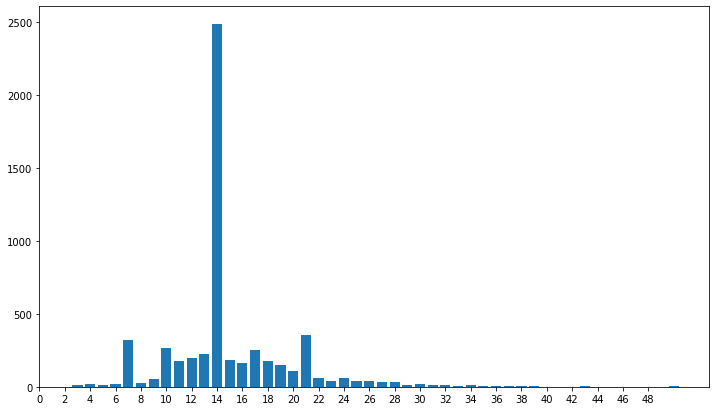

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.bar(x=list(freq.keys()), height=list(freq.values()))
plt.xticks(range(0, 50, 2))
plt.show()

In [ ]:
test_data[0].keys()

dict_keys(['src_doc_sent_list', 'tgt_sent_list', 'idx_extract'])

In [ ]:
f1 = []
p = []
r = []
for data in tqdm(test_data, total=len(test_data)):
    pred = data['src_doc_sent_list']
    candidate = set.union(*map(set, pred))
    candidate = set([x.lower() for x in candidate if x.isalpha() or x.isdigit()])
    
    gold = set.union(*map(set, data['tgt_sent_list']))
    gold = set([x.lower() for x in gold if x.isalpha() or x.isdigit()])
    rs_eval = abtract2extract.cal_rouge(candidate, gold)
    f1.append(rs_eval['f'])
    p.append(rs_eval['p'])
    r.append(rs_eval['r'])

print(f'F1: {np.mean(f1)}\nPrecidion: {np.mean(p)}\nRecall: {np.mean(r)}')


F1: 0.4174422498104231
Precidion: 0.3714610016167711
Recall: 0.5046799997269951
